In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV

#Задание 1

Создаем из данных таблицы task.csv и подгружаем его

In [ ]:
df = pd.read_csv('/content/task.csv')
df

,id,X,Y
0,1,4,10
1,2,22,41
2,3,20,36
3,4,7,17
4,5,13,31
5,6,12,35
6,7,17,47
7,8,3,10
8,9,1,5
9,10,21,41


Найдем выборочное среднее X

In [ ]:
float(df['X'].mean())

12.0

Найдем выборочное среднее Y

In [ ]:
float(df['Y'].mean())

27.3

Обучим модель линейной регрессии

In [ ]:
reg = LinearRegression().fit(df[['X']], df[['Y']])

Определим коэффициент $\theta_1$

In [ ]:
reg.coef_[0][0]

1.8202846975088967

Определим коэффициент $\theta_0$

In [ ]:
reg.intercept_[0]

5.456583629893242

Вычислим $R^2$ статистику

In [ ]:
y = reg.predict(df[['X']])
r2 = r2_score(df.Y, y)
r2

0.8808245804605275

#Задание 2

Дан набор данных о семи различных типах рыб, продаваемых в некоторой рыбной лавке. Цель заключается в том, чтобы предсказать массу рыбы по каким-то косвенным признакам, известным о рыбе.

In [ ]:
df = pd.read_csv('/content/fish_train.csv')
X = pd.DataFrame(df.drop(['Weight'], axis=1))
y = pd.DataFrame(df['Weight'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=df['Species'])

Вычислим выборочное среднее колонки `Width` полученной тренировочной выборки

In [ ]:
X_train['Width'].mean()

4.448602105263158

##Построение базовой модели

Избавимся от категориальных признаков

In [ ]:
X_train = X_train.drop(['Species'], axis=1)
X_test = X_test.drop(['Species'], axis=1)

Выполним предсказания для тестового набора данных и оценим модель при помощи метрики $r^2$.

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
y = reg.predict(X_test)
r2 = r2_score(y_test, y)
r2

0.8885408749541969

##Добавление предварительной обработки признаков

###Использование PCA

Выявим наиболее коррелированные признаки.

<Axes: >

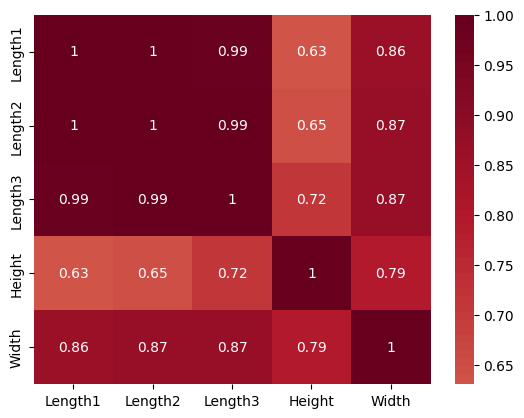

In [ ]:
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0)

Такими признаками являются `Length1`, `Length2`, `Length3`

Обучим модель PCA для трех этих признаков на тренировочных данных.

In [ ]:
pca = PCA(n_components=3, svd_solver='full')
pca.fit(X_train[['Length1', 'Length2', 'Length3']])
explained_variance = np.round(np.cumsum(pca.explained_variance_ratio_),3)
explained_variance

array([0.996, 1.   , 1.   ])

Доля объясненной дисперсии при использовании только первой главной компоненты - 0.996. Заменим тройку наиболее коррелированных признаков на признак `Lengths`, значения которого совпадают со счетами первой главной компоненты.

In [ ]:
X_train['Lengths'] = pca.transform(X_train[['Length1', 'Length2', 'Length3']])[:, 0]
X_train = X_train.drop(['Length1', 'Length2', 'Length3'], axis=1)

In [ ]:
X_test['Lengths'] = pca.transform(X_test[['Length1', 'Length2', 'Length3']])[:, 0]
X_test = X_test.drop(['Length1', 'Length2', 'Length3'], axis=1)

Обучим модель линейной регрессии.

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
y = reg.predict(X_test)
r2 = r2_score(y_test, y)
r2

0.8925481416058357

Метрика $r^2$ незначительно улучшилась.

###Модификация признаков

Возведем в куб значения признаков `Width`, `Height`, `Lengths`, чтобы получить более линейную зависимость.

In [ ]:
X_train['Width'] = X_train['Width'] ** 3
X_train['Height'] = X_train['Height'] ** 3
X_train['Lengths'] = X_train['Lengths'] ** 3
X_test['Width'] = X_test['Width'] ** 3
X_test['Height'] = X_test['Height'] ** 3
X_test['Lengths'] = X_test['Lengths'] ** 3

Найдем выборочное среднее колонки `Width` тренировочного набора данных после возведения в куб.

In [ ]:
X_train['Width'].mean()

124.41840117423388

Рассмотрим зависимость `Weight` от `Width` после преобразования.

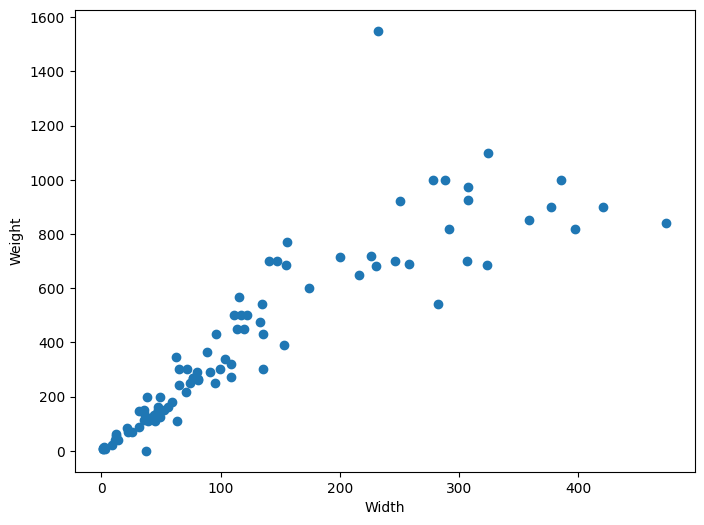

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train['Width'], y_train)
plt.xlabel('Width')
plt.ylabel('Weight')
plt.show()

Обучим модель линейнной регрессии.

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
y = reg.predict(X_test)
r2 = r2_score(y_test, y)
r2

0.9452890309259312

Метрика $r^2$ значительно улучшилась.

###Добавление категориальных признаков

Добавим к набору данных, полученному на предыдущем этапе, ранее исключенные категориальные признаки, предварительно произведя one-hot кодирование при помощи `pd.get_dummies()`.

In [ ]:
X_dummy = pd.get_dummies(X['Species'])

In [ ]:
X_train_dummy, X_test_dummy = train_test_split(X_dummy, test_size=0.2, random_state=23, stratify=df['Species'])

In [ ]:
X_train_with_species = pd.concat([X_train, X_train_dummy], axis=1)
X_test_with_species = pd.concat([X_test, X_test_dummy], axis=1)

Обучим модель регрессии. Рассчитаем $r^2$ полученной модели.

In [ ]:
reg = LinearRegression().fit(X_train_with_species, y_train)
y = reg.predict(X_test_with_species)
r2 = r2_score(y_test, y)
r2

0.9525713724639453

Закодируем категориальные признаки при помощи `pd.get_dummies(drop_first=True)`.Рассмотрим $r^2$ модели после избавления от коррелированности.

In [ ]:
X_dummy = pd.get_dummies(X['Species'], drop_first=True)
X_train_dummy, X_test_dummy = train_test_split(X_dummy, test_size=0.2, random_state=23, stratify=df['Species'])
X_train_with_species = pd.concat([X_train, X_train_dummy], axis=1)
X_test_with_species = pd.concat([X_test, X_test_dummy], axis=1)
reg = LinearRegression().fit(X_train_with_species, y_train)
y = reg.predict(X_test_with_species)
r2 = r2_score(y_test, y)
r2

0.9457535130010672

# Задание 3

Используя весь датасет из предыдущего задания как обучающий, выполним предсказания для зарезервированного набора данных. Для успешного выполнения задания необходимо, чтобы результат превысил пороговое значение, равное 0.98. В качестве метрики используется `r2_score`.

In [ ]:
df = pd.read_csv('fish_train.csv')
df_pred = pd.read_csv('fish_reserved.csv')

Возведем в квадрат значения признаков `Width`, `Height`, `Length1`, `Length2`, `Length3`, чтобы получить более линейную зависимость. Также закодируем категориальные признаки.

In [ ]:
def transform(df):
    df[['Width', 'Height', 'Length1', 'Length2', 'Length3']] = df[['Width', 'Height', 'Length1', 'Length2', 'Length3']].apply(lambda x: x**2)
    dummies = pd.get_dummies(df['Species'], drop_first=True)
    df[list(dummies.columns)] = dummies
    df.drop(['Species'], axis=1, inplace=True)

transform(df)
transform(df_pred)

Обучим модель на тренировочном наборе, оценим при помощи `r2_score`.

In [ ]:
X_train = pd.DataFrame(df.drop(['Weight'], axis=1))
y_train = pd.DataFrame(df['Weight'])
reg = LinearRegression().fit(X_train, y_train)
r2_score(y_train, reg.predict(X_train))

0.9763679932675075

In [ ]:
res = reg.predict(df_pred)
ans = res.flatten().tolist()
ans

[95.54714703871167,
 128.46800505093967,
 63.94296625237308,
 97.46840943969391,
 54.35372112425728,
 194.2229761229467,
 2.0622687077650426,
 512.8156880547618,
 420.9718970042222,
 78.17047303702878,
 1702.1038931855155,
 202.4813534872713,
 648.732525611242,
 1053.7357541293263,
 -48.45554844990653,
 649.2414718750432,
 124.72310702041352,
 794.3839441689566,
 1397.1767570934717,
 68.25122414222352,
 612.7740685910277,
 199.2718815849854,
 48.890973140172605,
 187.02194691004735,
 290.92770693340447,
 617.0075253289709,
 381.22874669096075,
 16.782873287947723,
 58.50194301457964,
 -4.3736570971974515,
 989.4756259279897,
 467.252559145797,
 556.864906932222,
 158.97556900763817,
 19.23690130305755,
 36.31956594554953,
 135.06112796281428,
 900.7334874469326,
 750.6943995182143,
 146.9837911063081]

На зарезервированном наборе результат показал значение `r2_score` равное 0.984052919119.